# <center> Projekt-Seminar Deep Learing (Prof. Dr. Jörn Hees)

## <center> Grupppe: Simon Lausch, Jan Felix Fuchs, Paul Jansen und Tobias Pappen

## <center> Deep Reinforcement Learning (Atari Spiel Freeway)

## <center> Notebook von Paul Jansen



### Einführung in das Projekt und Notebook

Hinweis: Grundlegende informationen und Dokumentation zum Spiel gibt es in der Baseline Dokumentation
(https://github.com/TobiasPapen/projekt-seminar-deep-q-learning)

Das folgende Notebook beinhaltet ein Deep Q-Learning Modell das auf der Baseline der Dreiergruppe basiert.

Abgrenzung zur Baseline:

* RGB Observation Space

* Observation Space Transformation (Cropped)

* Convolutional Neuronales Netz


Quellen:
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
%pip install gym[atari]
%pip install ale_py
%pip install autorom[accept-rom-license]
%pip install torch
%pip install gym[box2d]
%pip install torchvision
%pip install matplotlib

In [2]:
import gym
import math
import random
import numpy as np
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Reward Funktion (Zweite aus der Baseline)

In [3]:
class ClipReward_2(gym.RewardWrapper):
    #Method to initialize the updated reward function
    def __init__(self, env, min_reward, max_reward):
        #Inheritance: calling construtor of the super class
        super().__init__(env)

        #Saving the given parameters
        self.pre_pos = 6                                    #previous position of the chicken (lowest value = 6)
        self.min_reward = min_reward                        #minimum reward
        self.max_reward = max_reward                        #maximum reward
        self.reward_range = (min_reward, max_reward)        #range of the reward
        self.target_runs = 0                                #number of target runs

    #Method to calculate the reward
    def reward(self, reward):
        #Recieving the RAM
        ram = env.unwrapped.ale.getRAM()
        #Saving the current position and the cooldown value of the chicken
        #The cooldown value is not zero if the chicken got hit, was reset and now needs to wait for a short time
        current_pos = ram[14]
        cooldown = ram[106]

        if(current_pos >= 175):
            #Chicken reaches the goal
            reward = reward_goal
            self.target_runs += 1
        elif(self.pre_pos > 6 and (not cooldown == 0)):
            #Chicken collides with a car (reset)
            #By checking the cooldown value we are making sure that the we detect a "false" collision
            #Otherwise the agent would get a negative reward for moving forwards and then immediately backwards)
            reward = reward_crash
        #Chicken recieves a reward connected to its current position on the road (independent from crash or goal)
        reward += current_pos - (500 / current_pos)

        #Getting new previous position
        self.pre_pos = current_pos
        #Returning reward
        return np.clip(reward, self.min_reward, self.max_reward)

    #Method to recieve the number target runs
    def get_TargetRuns(self):
        return self.target_runs

    #Method to reset the number of target runs
    def reset_TargetRuns(self):
        self.target_runs = 0

Deep Q-Network mit Convolutional Layern und ReLU

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Initalisierung des Environment inkl. RGB Rendermode und Observation

In [5]:
env = ClipReward_2(gym.make("ALE/Freeway-v5", difficulty = 1, mode = 3, obs_type = "rgb", render_mode = "rgb_array"), -10000, 10000)
env.reset()

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 0, 'episode_frame_number': 3, 'frame_number': 3})

In [6]:
# Prüft ob Cuda verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


Transformation und überarbeitung des Observation Spaces

In [7]:
#Input Extracton / Transform
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=T.transforms.InterpolationMode.BILINEAR),
                    T.ToTensor()])
print("1")


def get_Chicken_location():
    return int(env.unwrapped.ale.getRAM()[14])  # MIDDLE OF CART

def get_screen():
    # env.Render übergibt ein RGB-Array
    # get_screen() transformiert dieses Array um Performanter zu Trainieren

    screen = env.render().transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # CROP image
    screen = T.functional.crop(screen, 20,0,175,100)
    size_h = T.functional.get_image_size(screen)[0]
    player_pos_prozent = (get_Chicken_location() / 175)
    #screen = T.functional.crop(screen, (size_h * player_pos_prozent)*100, 0,175,100)

    return resize(screen).unsqueeze(0)
env.reset()
#Folgender code auskommentiert um Plotting zu vermeiden (Kann Fehlermeldungen verursachen)
#plt.figure()
#plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
#plt.title('Test screen')
#plt.show()

1


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 0, 'episode_frame_number': 3, 'frame_number': 6})

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
Epsilon = 1 #Epsilon startwert
EPS_END = 0.05 #Minimaler Epsilon wert
EPS_DEC = 0.009 #Muss immer je nach größe der Durchläufe angepasst werden
TARGET_UPDATE = 10
eps_l_1 = []

init_screen = get_screen() #Grabt sich den ersten Screen des Environments
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n #Alle möglichen Aktionen

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > Epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

#Gibt die Liste aller Epsilon werte die über das Training gesammelt worden wieder
def get_eps():
    return eps_l_1

#Nach jedem Spiel wird Epsilon um den EPS_DEC wert verringert
def eps_dec_f():
    global Epsilon
    if Epsilon > EPS_END:
        Epsilon = Epsilon - EPS_DEC
    eps_l_1.append(Epsilon)


C:\Users\paul4\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [10]:
#Kommentare aus der Offiziellen Pytorch Dokumentation
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

### Training:

Um ein Training zu verhindert muss der wert 'num_episodes' auf 0 gesetzt werden.

In [11]:
num_episodes = 0 #Anzahl Trainings durchläufe (0 = Kein Training)
reward_goal = 10000 #Reward für das erreichen des Zieles
reward_crash = -1000 #Reward für das zusammenstoßen mit einem Auto
reward_l = [] #Liste der Rewards pro Game
target_l = [] #Liste der Scores pro Game
eps_l = [] #Liste des Epsilonverlauf pro Game
for i_episode in range(num_episodes):
    reward_game = 0
    print(f"Durchlauf {i_episode} von {num_episodes}")
    env.reset()
    last_screen = get_screen()
    #print("Get Screen Error") #Debugging
    current_screen = get_screen()
    state = current_screen - last_screen
    done = False
    count_frames = 0 # Zählt Frames des aktuellen Games
    eps_dec_f()
    while not done:
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward_game += reward
        #print(done) #Debugging
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        count_frames += 1
        #print("get screen check3 " + str(count_frames)) #Debuggin
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            reward_l.append(reward_game)
            target_runs = ClipReward_2.get_TargetRuns(env)
            target_l.append(target_runs)
            ClipReward_2.reset_TargetRuns(env)
            #episode_durations.append(count_frames + 1)
            #plot_durations()
            #break #Bricht training nach einen Durchlauf ab

        if count_frames % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')
print(reward_l)
print(target_l)
print(get_eps())

Complete
[]
[]
[]


## Ergebnisse

Die folgenden Ergebnisse des Trainings mussten Seperat aufbearbeitet werden da auf dem Trainings-Computer
die matplotlib Libary nicht funktionierte.
Alle Original Konsolen-Ausgaben sind vollständig zur Dokumentationszwecken bei Github (Diagramm CNN Paul) hochgeladen:
https://github.com/TobiasPapen/projekt-seminar-deep-q-learning/tree/master/Diagram%20CNN%20Paul

### Version 1
Durchläufe: 100
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

Durchschnitt = 1.43


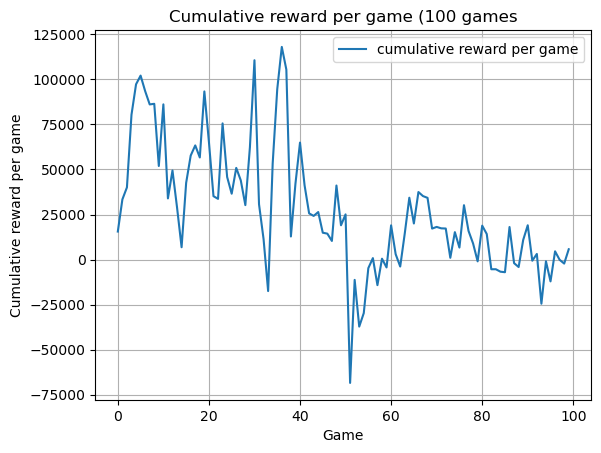

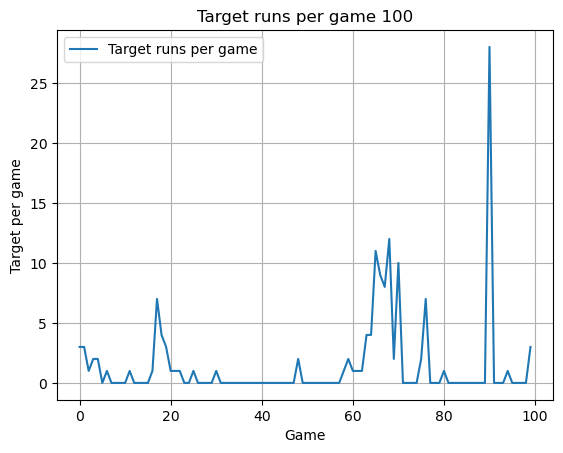

In [12]:
durchlaeufe = 100
reward_l = [15534.089366278236, 33371.625360748585, 40050.42578424262, 80362.79223289592, 97253.26552119845, 102085.89357266089, 93485.68520473859, 86093.47003460408, 86430.6684166868, 51919.283446969945, 86124.28011402431, 33940.0638885906, 49433.87109409379, 28952.54644169568, 6832.512354631882, 42534.42849106938, 57703.39133545149, 63343.32479790668, 56643.07178528527, 93297.7836328965, 65302.2451598579, 35170.729857610815, 33680.90434345364, 75563.21844203743, 45828.45997087675, 36537.990390183106, 50867.21290351133, 43907.4203429979, 30214.038209100356, 62309.89594492196, 110617.2909131871, 30696.74073307063, 11339.356321157435, -17487.488724398994, 53305.294252672786, 94531.09375269871, 118002.26586152402, 105441.5892003402, 12805.125472215592, 42136.51138357016, 64913.405308615576, 41250.16867943705, 25621.55045845815, 24215.711718193656, 26361.632203395093, 14893.811911289156, 14383.597651582337, 10322.240613439295, 41082.13946869631, 19026.67589766254, 25072.147833087536, -68466.6485427713, -11285.350805114675, -37214.62362561698, -29710.1626163695, -4768.035668588711, 801.1983293117949, -14196.173035615027, 475.16918356921764, -4377.64289245502, 18980.75338510559, 2987.8850072992623, -3873.0220860801824, 14492.768311840899, 34311.16382921894, 20025.54455313546, 37472.620911500184, 35226.415903706446, 34239.46214216285, 17184.45946912088, 18112.2960802321, 17327.01550307076, 17218.854698016432, 980.6878014089091, 15212.40740620722, 6645.6748564736135, 30162.16026221027, 15880.252986393016, 8911.842957224251, -1010.5641792190013, 18811.50664419214, 14177.127553401606, -5378.878853473791, -5380.161127674918, -6735.755423402432, -7025.138065808816, 18055.56382150889, -1987.6407376668508, -4147.943542331022, 10874.53659138072, 19032.691562950324, -633.6941091647748, 3111.225339964259, -24510.944036316065, -964.340851403585, -12121.413540137331, 4567.250212912411, -136.4438286024473, -2231.869937326936, 5714.7172179619365]

target_l = [3, 3, 1, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 7, 4, 3, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 4, 4, 11, 9, 8, 12, 2, 10, 0, 0, 0, 0, 2, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 1, 0, 0, 0, 0, 3]

print("Durchschnitt = " + str(sum(target_l) / durchlaeufe)) #Durchschnitt des Scores über alle 100 games

x = np.arange(0,durchlaeufe)
plt.plot(x, reward_l, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({durchlaeufe} games")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()


plt.plot(x, target_l, label = "Target runs per game")
plt.title(f"Target runs per game {durchlaeufe}")
plt.xlabel("Game")
plt.ylabel("Target per game")
plt.legend()
plt.grid()
plt.show()

 ### Version 2

Durchläufe: 25
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.001
EPS_DECAY = 200
TARGET_UPDATE = 10

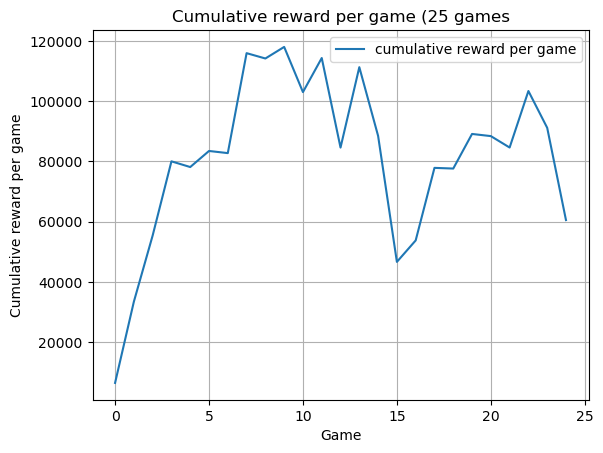

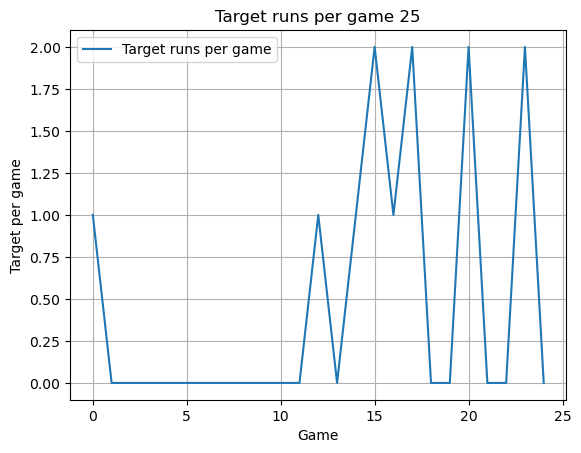

In [13]:
durchlaeufe = 25
reward_l = [6456.138037930415, 33431.709585732824, 55406.5704281588, 80041.30407931746, 78149.0755731125, 83487.49965156747, 82774.83457988802, 115971.41518024953, 114200.40347564778, 118041.03153887494, 103039.71191927668, 114356.06126916796, 84613.59883493227, 111317.6057815298, 88498.51359658799, 46652.75698639783, 53778.480792947244, 77874.22529970748, 77648.13361208719, 89137.06969394039, 88424.3191357758, 84628.16910551324, 103395.96152757888, 91180.02048236104, 60532.299522002155]

target_l = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0]

x = np.arange(0,durchlaeufe)
plt.plot(x, reward_l, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({durchlaeufe} games")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_l, label = "Target runs per game")
plt.title(f"Target runs per game {durchlaeufe}")
plt.xlabel("Game")
plt.ylabel("Target per game")
plt.legend()
plt.grid()
plt.show()

### Version 3

BATCH_SIZE = 128
GAMMA = 0.999
Epsilon = 1
EPS_END = 0.05
EPS_DEC = 0.009
TARGET_UPDATE = 10

(Änderung der Epsilon Berechnung)

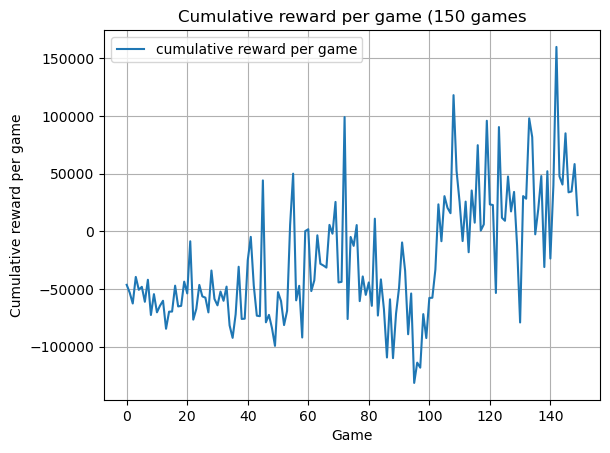

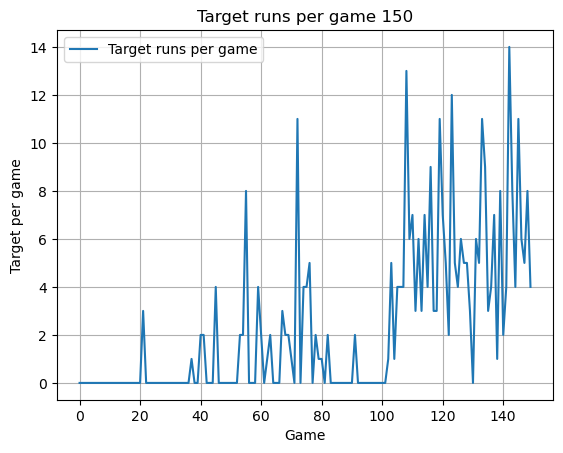

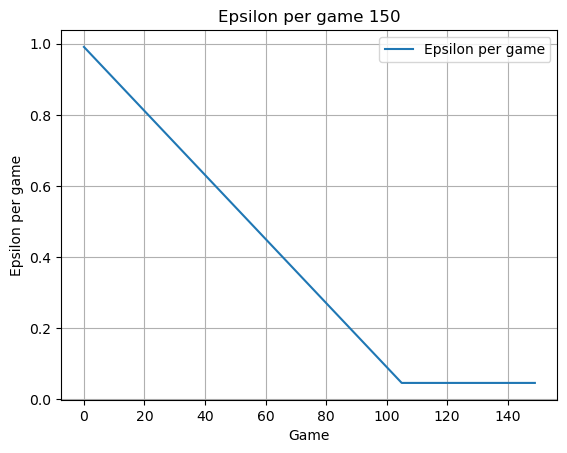

Durchschnitt = 2.2733333333333334
Durchschnitt (120-150) = 6.033333333333333
Max. Score 14
Min. Score 0


In [14]:
durchlaeufe = 150
reward_l = [-46305.99482831709, -53164.60264063564, -62508.255507721355, -39433.86466359415, -50607.81764436985, -48027.591697575044, -61005.863692589126, -41924.75343804736, -72455.6952741279, -54400.20510057123, -70144.64224048653, -64432.54540610039, -60111.056646895195, -84388.58174732653, -69594.58087369146, -69485.20675694238, -47049.190128195085, -65032.041011673595, -64540.68686896858, -43536.13805123844, -53751.08015706992, -8567.0772642266, -76465.25867023134, -67187.64997072947, -46382.09191746007, -56355.11832584178, -57430.588654878185, -70201.34130346777, -33902.347653592005, -58515.10829029944, -64104.788926747526, -52167.35818798453, -60159.84542944782, -47865.800824532496, -81482.7300096771, -92304.39111233971, -71849.03677610471, -30639.294463452257, -75898.61166679703, -75669.52132375883, -24936.83887375382, -4729.6936607623575, -47219.836248285326, -73056.85369527062, -73500.04851848172, 44212.05407140541, -78825.14633954462, -72354.58757081525, -83743.75785701004, -99227.51300992981, -52633.853797244956, -60404.86876251796, -81190.84475176664, -68838.51987998714, 5599.343909933368, 50053.26123444128, -59766.41220063686, -47168.06510407441, -91966.98949209932, 276.38349193339434, 1892.792430929578, -51714.729888437076, -42369.38727617858, -3390.9521963391444, -28064.31121300446, -29550.3741459102, -31379.21670786996, 5666.540233416593, -1981.897292422796, 25561.66135155996, -44228.23864410941, -43744.452976951696, 99137.88785726274, -75953.08461974423, -4802.035610206806, -12545.093287837055, 5492.554596161454, -60445.02134465606, -39054.799905557804, -55034.518357100926, -44215.31468378128, -64519.815178263016, 11032.293983574078, -72940.75167695766, -41598.81992588817, -67418.8867910932, -109307.48739094108, -58863.47759119179, -109881.47506702536, -71320.9505210556, -48757.07433403922, -9578.413551322476, -34175.63593572353, -89167.81914523877, -53811.452404417076, -131353.1757618184, -113777.83187585935, -118122.90718836998, -71707.08865431488, -92455.60714001904, -57665.66627863912, -57503.41565986795, -33064.401000657796, 23463.607565189308, -8513.903669676682, 30552.570597341193, 20487.540922444, 15772.624073424184, 118126.858576995, 52484.57425354201, 25500.766148003637, -8374.492397628066, 25838.244019157515, -18054.372421871998, 35481.299675016395, 7571.084800313524, 74746.04523655945, 714.6813633704209, 6080.885899035177, 95929.27968919335, 23434.822091607108, 22873.119872794843, -53371.055620040184, 90465.9611953468, 11801.830320743402, 9208.499576862847, 47613.75560257946, 17323.31976785847, 34225.044285070035, -12252.841525677719, -78949.30046887985, 30612.132823655964, 28357.051603099288, 98028.73911910166, 81779.88709581857, -2527.4830191448327, 19295.94566443301, 47965.99467961297, -30895.05531990578, 52158.888860884595, -23524.635975790283, 39998.36802878002, 159931.97954664644, 47793.40242525954, 40611.71260904171, 85028.08785452481, 33868.887535714886, 34649.98613684093, 58370.69346684657, 14110.187301850081]

target_l = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 8, 0, 0, 0, 4, 2, 0, 1, 2, 0, 0, 0, 3, 2, 2, 1, 0, 11, 0, 4, 4, 5, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 1, 4, 4, 4, 13, 6, 7, 3, 6, 3, 7, 4, 9, 3, 3, 11, 7, 5, 2, 12, 5, 4, 6, 5, 5, 3, 0, 6, 5, 11, 9, 3, 4, 7, 1, 8, 2, 4, 14, 8, 4, 11, 6, 5, 8, 4]

eps_l = [0.991, 0.982, 0.973, 0.964, 0.955, 0.946, 0.9369999999999999, 0.9279999999999999, 0.9189999999999999, 0.9099999999999999, 0.9009999999999999, 0.8919999999999999, 0.8829999999999999, 0.8739999999999999, 0.8649999999999999, 0.8559999999999999, 0.8469999999999999, 0.8379999999999999, 0.8289999999999998, 0.8199999999999998, 0.8109999999999998, 0.8019999999999998, 0.7929999999999998, 0.7839999999999998, 0.7749999999999998, 0.7659999999999998, 0.7569999999999998, 0.7479999999999998, 0.7389999999999998, 0.7299999999999998, 0.7209999999999998, 0.7119999999999997, 0.7029999999999997, 0.6939999999999997, 0.6849999999999997, 0.6759999999999997, 0.6669999999999997, 0.6579999999999997, 0.6489999999999997, 0.6399999999999997, 0.6309999999999997, 0.6219999999999997, 0.6129999999999997, 0.6039999999999996, 0.5949999999999996, 0.5859999999999996, 0.5769999999999996, 0.5679999999999996, 0.5589999999999996, 0.5499999999999996, 0.5409999999999996, 0.5319999999999996, 0.5229999999999996, 0.5139999999999996, 0.5049999999999996, 0.49599999999999955, 0.48699999999999954, 0.47799999999999954, 0.46899999999999953, 0.4599999999999995, 0.4509999999999995, 0.4419999999999995, 0.4329999999999995, 0.4239999999999995, 0.4149999999999995, 0.4059999999999995, 0.39699999999999946, 0.38799999999999946, 0.37899999999999945, 0.36999999999999944, 0.36099999999999943, 0.3519999999999994, 0.3429999999999994, 0.3339999999999994, 0.3249999999999994, 0.3159999999999994, 0.3069999999999994, 0.2979999999999994, 0.28899999999999937, 0.27999999999999936, 0.27099999999999935, 0.26199999999999934, 0.25299999999999934, 0.24399999999999933, 0.23499999999999932, 0.2259999999999993, 0.2169999999999993, 0.2079999999999993, 0.1989999999999993, 0.18999999999999928, 0.18099999999999927, 0.17199999999999926, 0.16299999999999926, 0.15399999999999925, 0.14499999999999924, 0.13599999999999923, 0.12699999999999922, 0.11799999999999923, 0.10899999999999924, 0.09999999999999924, 0.09099999999999925, 0.08199999999999925, 0.07299999999999926, 0.06399999999999927, 0.054999999999999265, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264, 0.045999999999999264]

x = np.arange(0,durchlaeufe)
plt.plot(x, reward_l, label = "cumulative reward per game")                          #Cumulative reward per game
plt.title(f"Cumulative reward per game ({durchlaeufe} games")
plt.xlabel("Game")
plt.ylabel("Cumulative reward per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, target_l, label = "Target runs per game")
plt.title(f"Target runs per game {durchlaeufe}")
plt.xlabel("Game")
plt.ylabel("Target per game")
plt.legend()
plt.grid()
plt.show()

plt.plot(x, eps_l, label = "Epsilon per game")
plt.title(f"Epsilon per game {durchlaeufe}")
plt.xlabel("Game")
plt.ylabel("Epsilon per game")
plt.legend()
plt.grid()
plt.show()

print("Durchschnitt = " + str(sum(target_l) / durchlaeufe)) #Durchschnitt des Scores über alle 150 games

print("Durchschnitt (120-150) = " + str(sum(target_l[119:149]) / 30)) #Durchschnitt der letzten 30 games

print("Max. Score " + str(max(target_l)))

print("Min. Score " + str(min(target_l)))